# 회귀분석
## 단순회귀분석

In [1]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
# 선형회귀 참조 코드
from statsmodels.formula.api import ols
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [2]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('cars')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리

데이터셋 크기: (50, 2)
열 개수: 2
행 개수: 50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


## 탐색적 데이터 분석

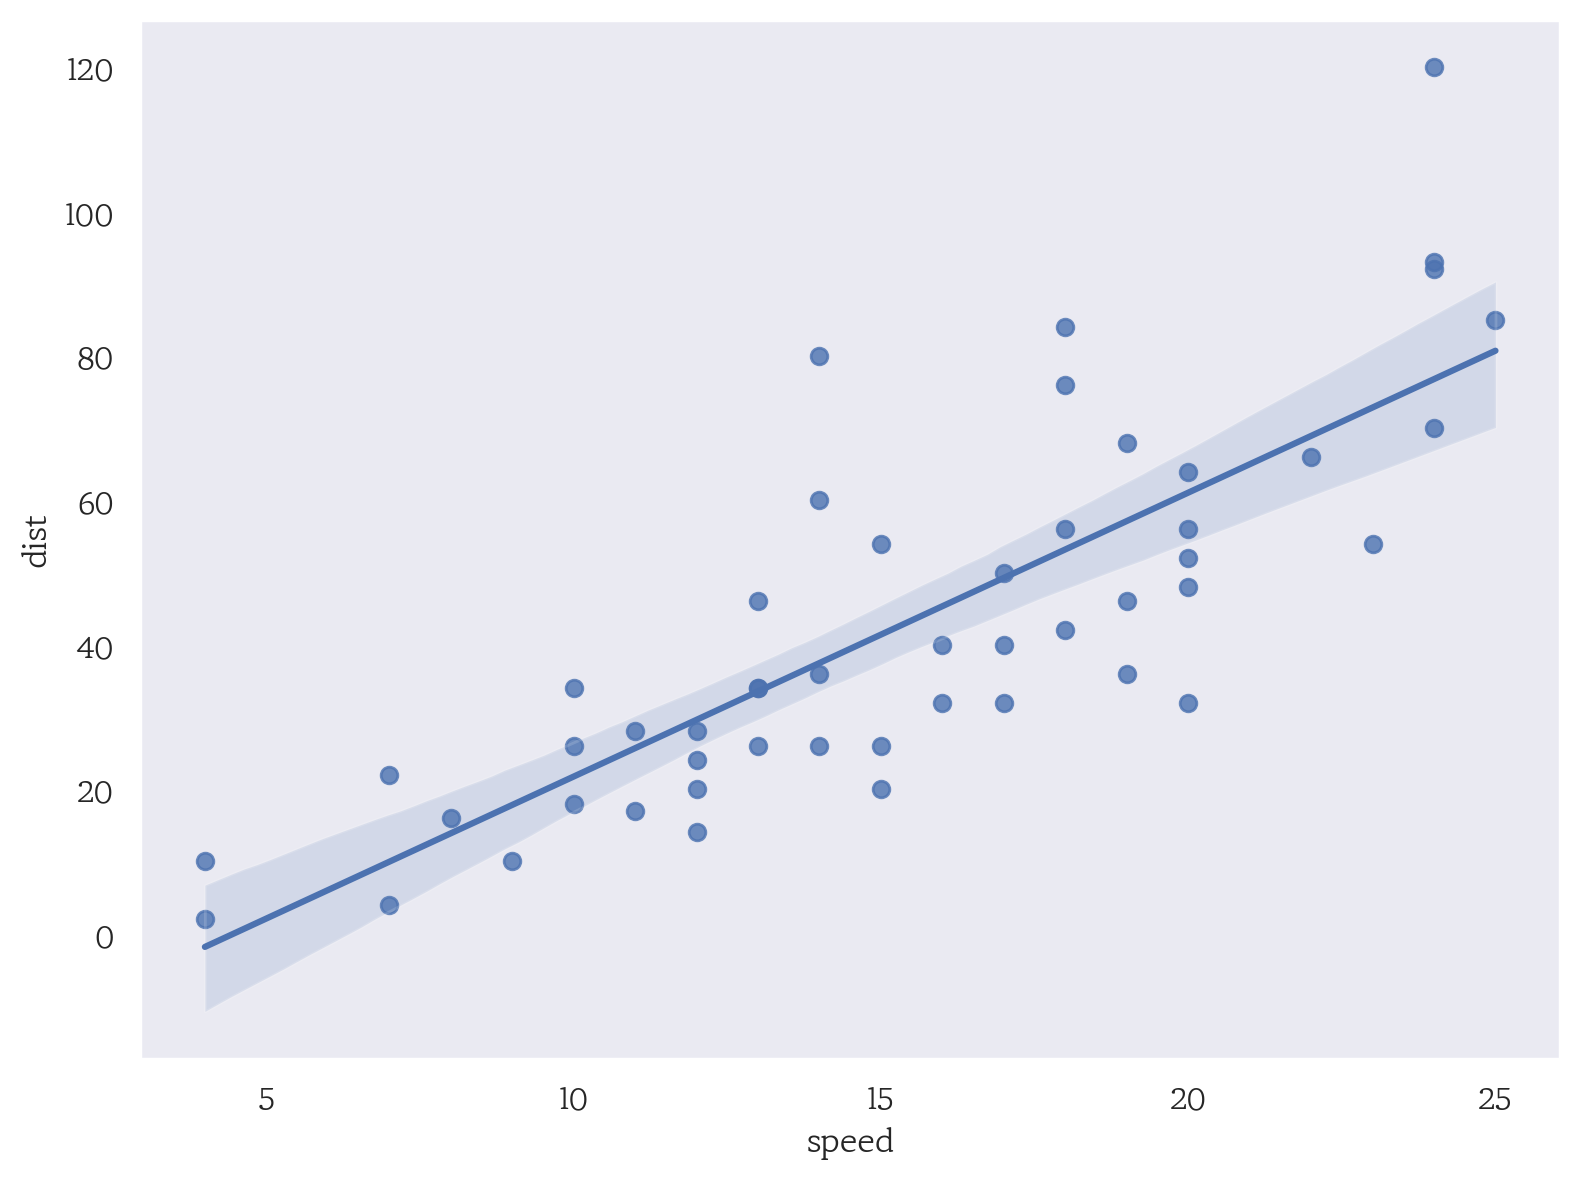

In [4]:
# 선형성 - 페어플롯

width_px = 1600
height_px = 1200
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)
# pairplot 그리기
# 'corner=True' 파라미터 추가 시 아래쪽 삼각형만 플롯된다
# 'diag_kind' 파라미터에 'hist'값 적용, 'kde': 기본값, 범주별 구분 시 사용
# x_vars, y_vars 파라미터에 원하는 변수를 선택적으로 적용한다, 선택적 변수 적용 시 사용
sb.regplot(data = origin, x = 'speed', y = 'dist') 
               #x_vars = ['⭐', '⭐', '⭐'],
               #y_vars = ['⭐', '⭐'])

# 출력
plt.tight_layout()
plt.show()
plt.close()

## 추론통계
### 상관분석


=== 이상치 확인 ===
이상치 존재


,original_skew,log_skew,outliers(|z|>3)
speed,-0.117510,-1.668586,0.0
dist,0.806895,-1.384501,1.0


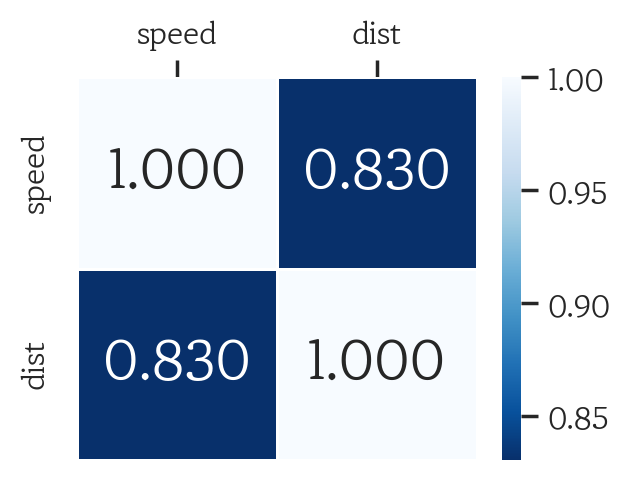


=== 상관분석 보고서 ===

본 분석에서는 speed과 dist 간 상관관계를 검토하였다.

데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.

분석 결과, 스피어만 상관계수는 r = 0.830, p = 0.000(으)로 나타났으며, 두 변수 간 양의 단조 관계가 존재함을 확인하였다.


In [6]:
xname = 'speed'
yname = 'dist'

# ---------------------------------
# 선형성 가정 확인 -> 산점도 기반 가정 (여기서는 True 고정)
# ---------------------------------
linearity_ok = True

# ---------------------------------
# 이상치와 왜도 검정
# ---------------------------------
data = origin[[xname, yname]]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 왜도 계산 (음수 방지 위해 +1 shift)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count
    }

results_df = DataFrame(results).T

# 이상치 존재 여부
outlier_flag = results_df['outliers(|z|>3)'].sum() > 0

print("\n=== 이상치 확인 ===")
print("이상치 존재" if outlier_flag else "이상치 없음")
display(results_df)

# ---------------------------------
# 상관분석
# ---------------------------------
report = f"본 분석에서는 {xname}과 {yname} 간 상관관계를 검토하였다.\n\n"

# 1. 상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearsonr(origin[xname], origin[yname])

    if pval > 0.05:
        report += (
            "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
        )
    else:
        report += (
            f"데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 "
            f"피어슨 상관계수를 사용하였다.\n\n"
            f"분석 결과, 피어슨 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타났으며, "
            f"두 변수 간 {'양의 상관' if corr > 0 else '음의 상관'} 관계가 "
            "통계적으로 유의함을 확인하였다."
        )

else:
    chosen = 'spearman'
    corr, pval = spearmanr(origin[xname], origin[yname])

    if pval > 0.05:
        report += (
            "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
        )
    else:
        report += (
            f"데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 "
            f"스피어만 상관계수를 사용하였다.\n\n"
            f"분석 결과, 스피어만 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타났으며, "
            f"두 변수 간 {'양의 단조' if corr > 0 else '음의 단조'} 관계가 존재함을 확인하였다."
        )

# ---------------------------------
# 결과 시각화 Heatmap
# ---------------------------------
corr_matrix = origin[[xname, yname]].corr(method=chosen)

width_px = 650
height_px = 500
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.3f",
    linewidth=0.5,
    cmap="Blues_r",
    annot_kws={"size": 20},
    ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()

# ---------------------------------
# 최종 보고 출력
# ---------------------------------
print("\n=== 상관분석 보고서 ===\n")
print(report)

## 단순선형회귀

In [7]:
x = origin[['speed']]
x.head()

,speed
0,4
1,4
2,7
3,7
4,8


In [8]:
y = origin['dist']
y.head()

0     2
1    10
2     4
3    22
4    16
Name: dist, dtype: int64

In [9]:
X = sm.add_constant(x)
X

,const,speed
0,1.0,4
1,1.0,4
2,1.0,7
3,1.0,7
4,1.0,8
5,1.0,9
6,1.0,10
7,1.0,10
8,1.0,10
9,1.0,11


In [10]:
# OLS 모델 객체 생성
model = sm.OLS(y,X)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                   목, 11 12 2025   Prob (F-statistic):           1.49e-12
Time:                        11:48:49   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

## 결과 보고
### 모형 적합도 보고 

- 회귀모형이 통계적으로 유의한지 판단하기 위해 F통계량, 자유도(df1, df2), p-value 그리고 설명력(R2)를 함께 보고
- 보고 템플릿
    dist를 종속변수로, speed를 독립변수로 한 단순회귀분석 결과, 모형은 통계적으로 유의하였다.
    F(1, 48) = 89.57, p < 0.001, R² = 0.651.
    즉, speed는 dist의 약 65.1%를 설명하는 것으로 나타났다.


### 독립변수 보고

- speed의 회귀계수는 β = 3.93으로 나타났으며, 이는 dist에 유의미하게 정(+)적 영향을 미쳤다.
    t(48) = 9.46, p < 0.001.
    즉, speed가 1 증가할 때 dist는 평균적으로 3.93 증가하는 것으로 해석된다.

## 실제 데이터와 예측값 비교

In [16]:
df = origin.copy()
df['y_pred'] = fit.predict(X)
df.head()

,speed,dist,y_pred
0,4,2,-1.849460
1,4,10,-1.849460
2,7,4,9.947766
3,7,22,9.947766
4,8,16,13.880175


In [17]:
df_melt = df.melt(
 id_vars="speed", # speed는 그대로 둠
 value_vars=["dist", "y_pred"], # long 형태로 변환할 변수
 var_name="variable", # 명목형 변수명
 value_name="value" # 값 변수명
)
df_melt.head()

,speed,variable,value
0,4,dist,2.0
1,4,dist,10.0
2,7,dist,4.0
3,7,dist,22.0
4,8,dist,16.0


## 연습문제

In [18]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
# 선형회귀 참조 코드
from statsmodels.formula.api import ols
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [19]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [20]:
origin = load_data('father-son')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab12_/father-son.xlsx
[desc] 아버지와 아들의 키를 조사한 데이터 (출처: https://www.kaggle.com/datasets/aungdev/pearson-dataset-heights-of-fathers-and-their-sons)

field    description
-------  -------------------
fheight  아버지의 키(Inches)
sheight  아들의 키(Inches)

데이터셋 크기: (1078, 2)
열 개수: 2
행 개수: 1078
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fheight  1078 non-null   float64
 1   sheight  1078 non-null   float64
dtypes: float64(2)
memory usage: 17.0 KB
None


,fheight,sheight
0,65.04851,59.77827
1,63.25094,63.21404
2,64.95532,63.34242
3,65.75250,62.79238
4,61.13723,64.28113


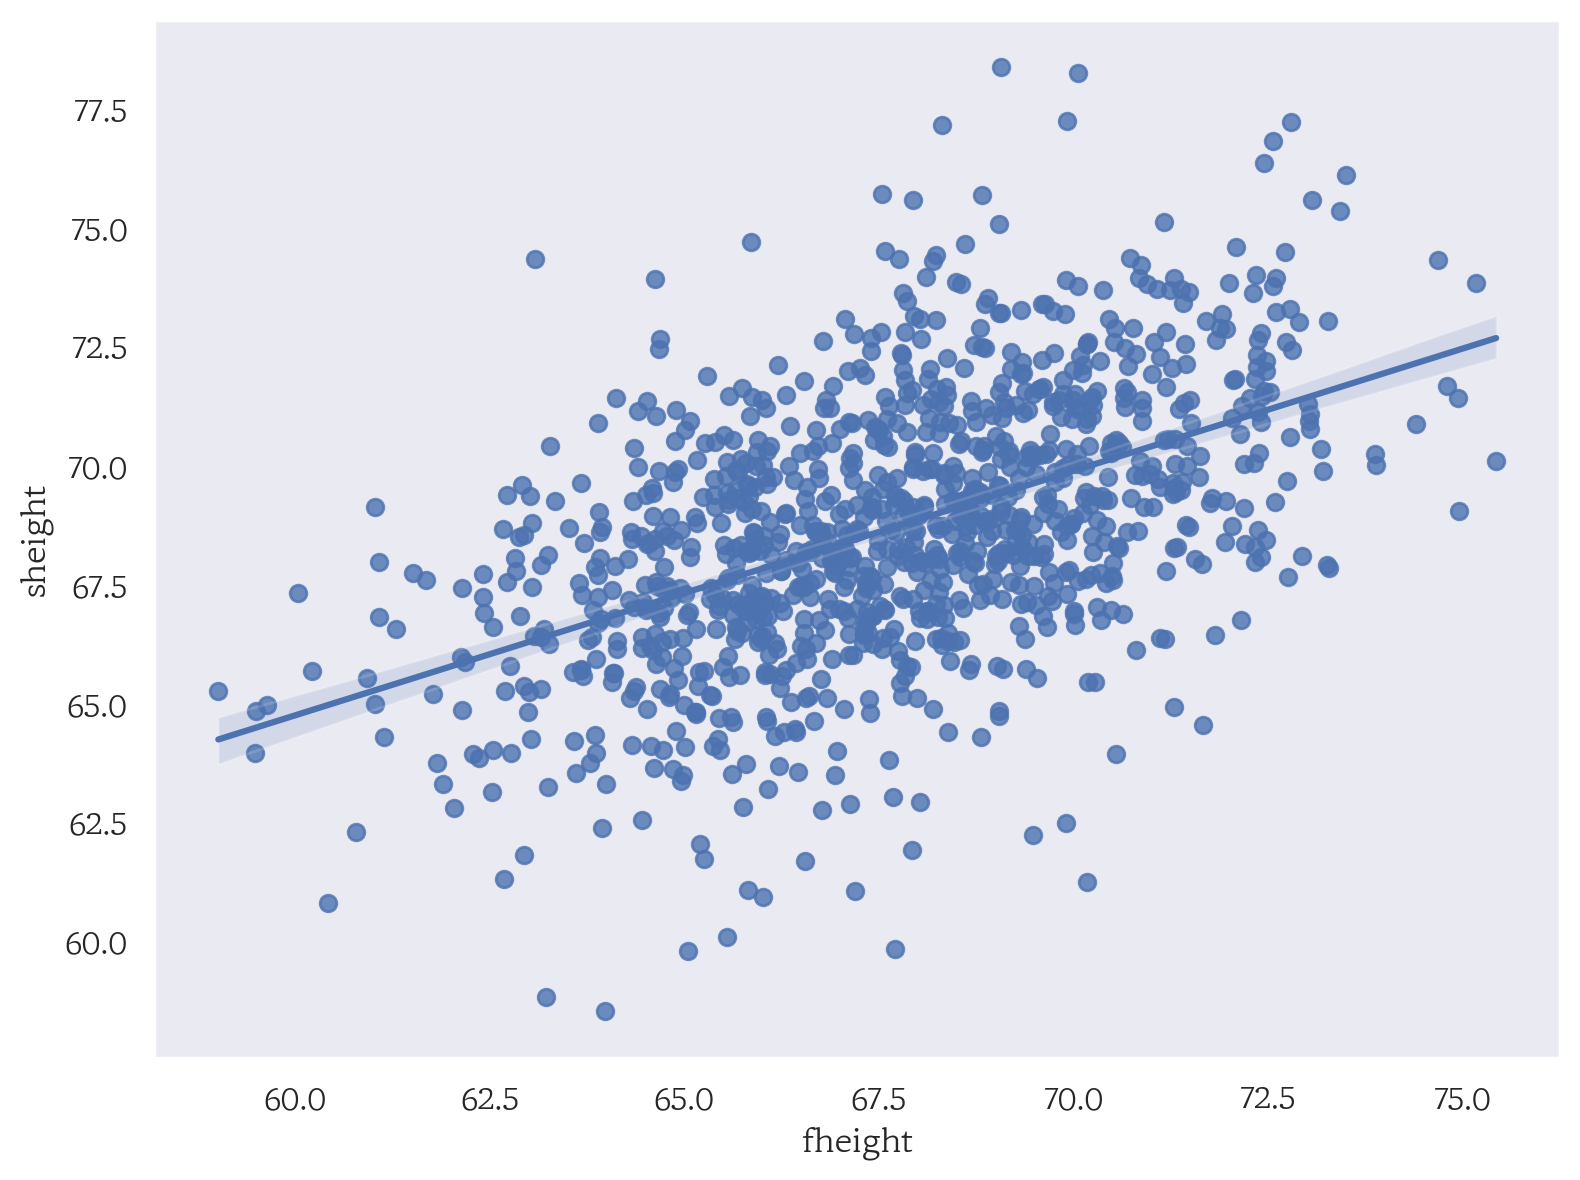

In [21]:
# 선형성 - 페어플롯

width_px = 1600
height_px = 1200
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)
# pairplot 그리기
# 'corner=True' 파라미터 추가 시 아래쪽 삼각형만 플롯된다
# 'diag_kind' 파라미터에 'hist'값 적용, 'kde': 기본값, 범주별 구분 시 사용
# x_vars, y_vars 파라미터에 원하는 변수를 선택적으로 적용한다, 선택적 변수 적용 시 사용
sb.regplot(data = origin, x = 'fheight', y = 'sheight') 
               #x_vars = ['⭐', '⭐', '⭐'],
               #y_vars = ['⭐', '⭐'])

# 출력
plt.tight_layout()
plt.show()
plt.close()


=== 이상치 확인 ===
이상치 존재


,original_skew,log_skew,outliers(|z|>3)
fheight,-0.088268,-1.155431,1.0
sheight,-0.036696,-1.401806,10.0


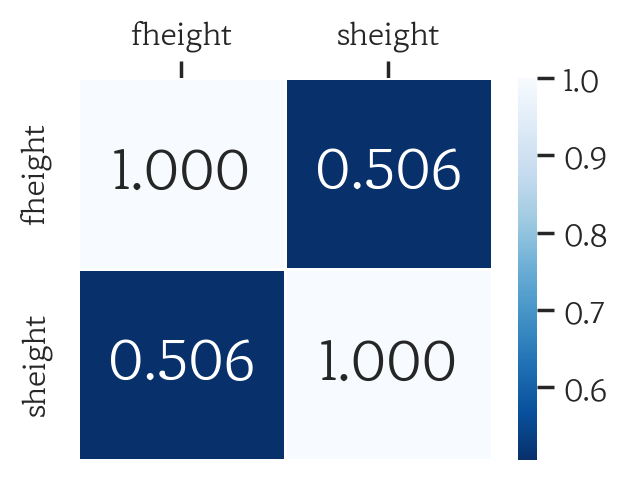


=== 상관분석 보고서 ===

본 분석에서는 fheight과 sheight 간 상관관계를 검토하였다.

데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.

분석 결과, 스피어만 상관계수는 r = 0.506, p = 0.000(으)로 나타났으며, 두 변수 간 양의 단조 관계가 존재함을 확인하였다.


In [24]:
xname = 'fheight'
yname = 'sheight'

# ---------------------------------
# 선형성 가정 확인 -> 산점도 기반 가정 (여기서는 True 고정)
# ---------------------------------
linearity_ok = True

# ---------------------------------
# 이상치와 왜도 검정
# ---------------------------------
data = origin[[xname, yname]]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 왜도 계산 (음수 방지 위해 +1 shift)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count
    }

results_df = DataFrame(results).T

# 이상치 존재 여부
outlier_flag = results_df['outliers(|z|>3)'].sum() > 0

print("\n=== 이상치 확인 ===")
print("이상치 존재" if outlier_flag else "이상치 없음")
display(results_df)

# ---------------------------------
# 상관분석
# ---------------------------------
report = f"본 분석에서는 {xname}과 {yname} 간 상관관계를 검토하였다.\n\n"

# 1. 상관계수 선택
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearsonr(origin[xname], origin[yname])

    if pval > 0.05:
        report += (
            "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
        )
    else:
        report += (
            f"데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 "
            f"피어슨 상관계수를 사용하였다.\n\n"
            f"분석 결과, 피어슨 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타났으며, "
            f"두 변수 간 {'양의 상관' if corr > 0 else '음의 상관'} 관계가 "
            "통계적으로 유의함을 확인하였다."
        )

else:
    chosen = 'spearman'
    corr, pval = spearmanr(origin[xname], origin[yname])

    if pval > 0.05:
        report += (
            "데이터 점검 결과, 두 변수의 관계는 통계적으로 유의하지 않았다."
        )
    else:
        report += (
            f"데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 "
            f"스피어만 상관계수를 사용하였다.\n\n"
            f"분석 결과, 스피어만 상관계수는 r = {corr:0.3f}, p = {pval:0.3f}(으)로 나타났으며, "
            f"두 변수 간 {'양의 단조' if corr > 0 else '음의 단조'} 관계가 존재함을 확인하였다."
        )

# ---------------------------------
# 결과 시각화 Heatmap
# ---------------------------------
corr_matrix = origin[[xname, yname]].corr(method=chosen)

width_px = 650
height_px = 500
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.3f",
    linewidth=0.5,
    cmap="Blues_r",
    annot_kws={"size": 20},
    ax=ax
)

ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()

# ---------------------------------
# 최종 보고 출력
# ---------------------------------
print("\n=== 상관분석 보고서 ===\n")
print(report)

In [26]:
x = origin[['fheight']]
x.head()
y = origin['sheight']
y.head()
X = sm.add_constant(x)
X
# OLS 모델 객체 생성
model = sm.OLS(y,X)
fit = model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                sheight   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     361.2
Date:                   목, 11 12 2025   Prob (F-statistic):           1.12e-69
Time:                        12:09:36   Log-Likelihood:                -2488.7
No. Observations:                1078   AIC:                             4981.
Df Residuals:                    1076   BIC:                             4991.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.8866      1.832     18.493      0.0

# 회귀분석 가정 검정

In [11]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
# 선형회귀 참조 코드
from statsmodels.formula.api import ols
from pandas import DataFrame, melt
import statsmodels.api as sm

from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, kstest
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

In [3]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [4]:
origin = load_data('cars')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리

데이터셋 크기: (50, 2)
열 개수: 2
행 개수: 50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


## 단순선형회귀

In [6]:
yname = 'dist'
x = origin.drop(yname, axis = 1)
y = origin[yname]
X = sm.add_constant(x)
fit = sm.OLS(y, X).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                   목, 11 12 2025   Prob (F-statistic):           1.49e-12
Time:                        15:33:17   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

## 잔차 구하기
### 예측값 구하기

In [ ]:
y_pred = fit.predict(X)
y_pred.head()

# 회귀분석 결과 객체 안에 내장되어 있는 예측값
#y_pred = fit.fittedvalues
#y_pred

0    -1.849460
1    -1.849460
2     9.947766
3     9.947766
4    13.880175
dtype: float64

### 잔차값 구하기

In [8]:
residual = fit.resid
residual.head()

0     3.849460
1    11.849460
2    -5.947766
3    12.052234
4     2.119825
dtype: float64

### 분석 데이터에 결합

In [9]:
df = origin.copy()
df['y_pred'] = y_pred
df['resid'] = residual
df.head()

,speed,dist,y_pred,resid
0,4,2,-1.849460,3.849460
1,4,10,-1.849460,11.849460
2,7,4,9.947766,-5.947766
3,7,22,9.947766,12.052234
4,8,16,13.880175,2.119825


## 잔차의 선형성 검정
### 시각화를 통한 검정

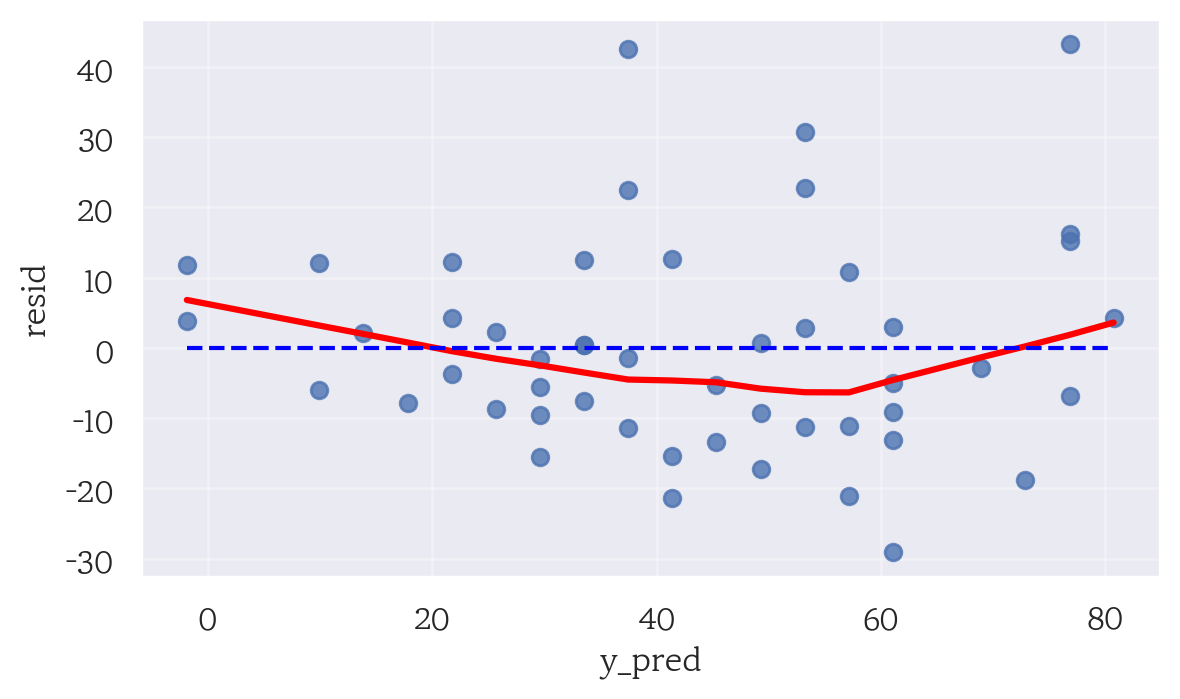

In [15]:
xmin = df['y_pred'].min()
xmax = df['y_pred'].max()
xrange = [xmin, xmax]
yrange = [0,0]
width_px = 1200
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# point 그리기
sb.regplot(data=df,            # 사용할 데이터프레임
           x = 'y_pred',            # 막대의 카테고리축
           y ='resid',   # 요약할 수치변수    
           lowess=True,
           line_kws = {'color':'red'})
sb.lineplot(x = xrange, y = yrange, color = 'blue', linestyle ='--')        # 요약 방식: np.mean, np.median

ax.grid(True, alpha = 0.3)

# 출력
plt.tight_layout()
plt.savefig('myplot.png', dpi = my_dpi)
plt.show()
plt.close()

## 통계량을 위한 검정

In [16]:
reset_res = linear_reset(fit, power = 2, use_f = True)
print(f'RESET F-statistic: {reset_res.fvalue:.4f}')
print(f'p-value: {reset_res.pvalue:.4f}')

if reset_res.pvalue < 0.05:
    print('선형성/기능형 위배 가능성이 있음 (5% 유의수준)')
else:
     print('선형성 가정 위배 근거 없음 (5% 유의수준)')    

RESET F-statistic: 2.2960
p-value: 0.1364
선형성 가정 위배 근거 없음 (5% 유의수준)


## 잔차의 정규성
### 잔차가 정규분포를 따르는지 확인

In [17]:
df['zscore'] = zscore(df['y_pred'])
df.head()

,speed,dist,y_pred,resid,zscore
0,4,2,-1.849460,3.849460,-2.177858
1,4,10,-1.849460,11.849460,-2.177858
2,7,4,9.947766,-5.947766,-1.604738
3,7,22,9.947766,12.052234,-1.604738
4,8,16,13.880175,2.119825,-1.413697


### Q-Q플롯 좌표 구하기

In [18]:
(x,y), _ = probplot(df['zscore'])
display(x[:5])
display(y[:5])

array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759])

array([-2.17785805, -2.17785805, -1.60473751, -1.60473751, -1.41369733])

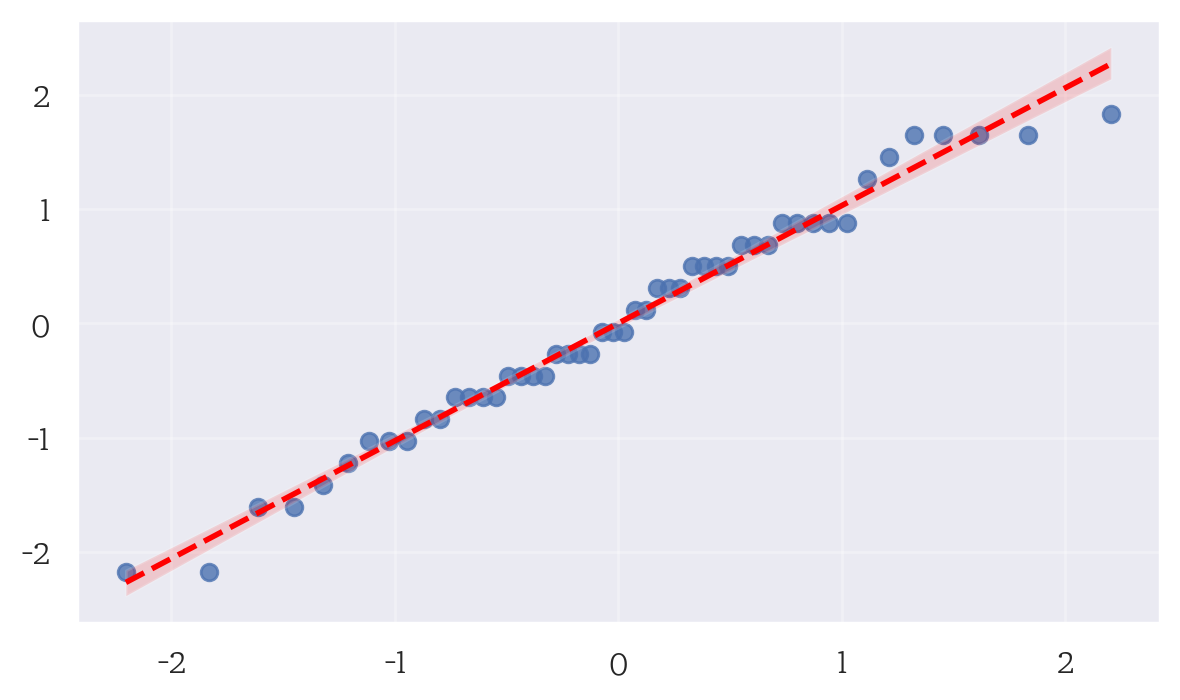

In [20]:
width_px = 1200
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# count 그리기
sb.regplot(
             x =x,
             y= y,
             line_kws={
                 'color': 'red',
                 'linestyle': '--',
                 'linewidth': 2
             }                        
          )       

ax.grid(True, alpha = 0.3)

# 출력
plt.tight_layout()
plt.savefig('myplot.png', dpi = my_dpi)
plt.show()
plt.close()

## 잔차도를 통한 검정
### 잔차의 분산(MSE)를 통해 검정

In [21]:
MSE_sq = np.sqrt(fit.mse_resid) # 잔차 분산의 제곱근
r = fit.resid # 잔차
r1 = r[ (r > -MSE_sq) & (r < MSE_sq)].count() / r.count() * 100
r2 = r[ (r > -2*MSE_sq) & (r < 2*MSE_sq)].count() / r.count() * 100
r3 = r[ (r > -3*MSE_sq) & (r < 3*MSE_sq)].count() / r.count() * 100
mse_r = [r1, r2, r3]
print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")


루트 1MSE 구간에 포함된 잔차 비율: 74.00%
루트 2MSE 구간에 포함된 잔차 비율: 94.00%
루트 3MSE 구간에 포함된 잔차 비율: 100.00%


## 잔차도 시각화
### resid 플롯

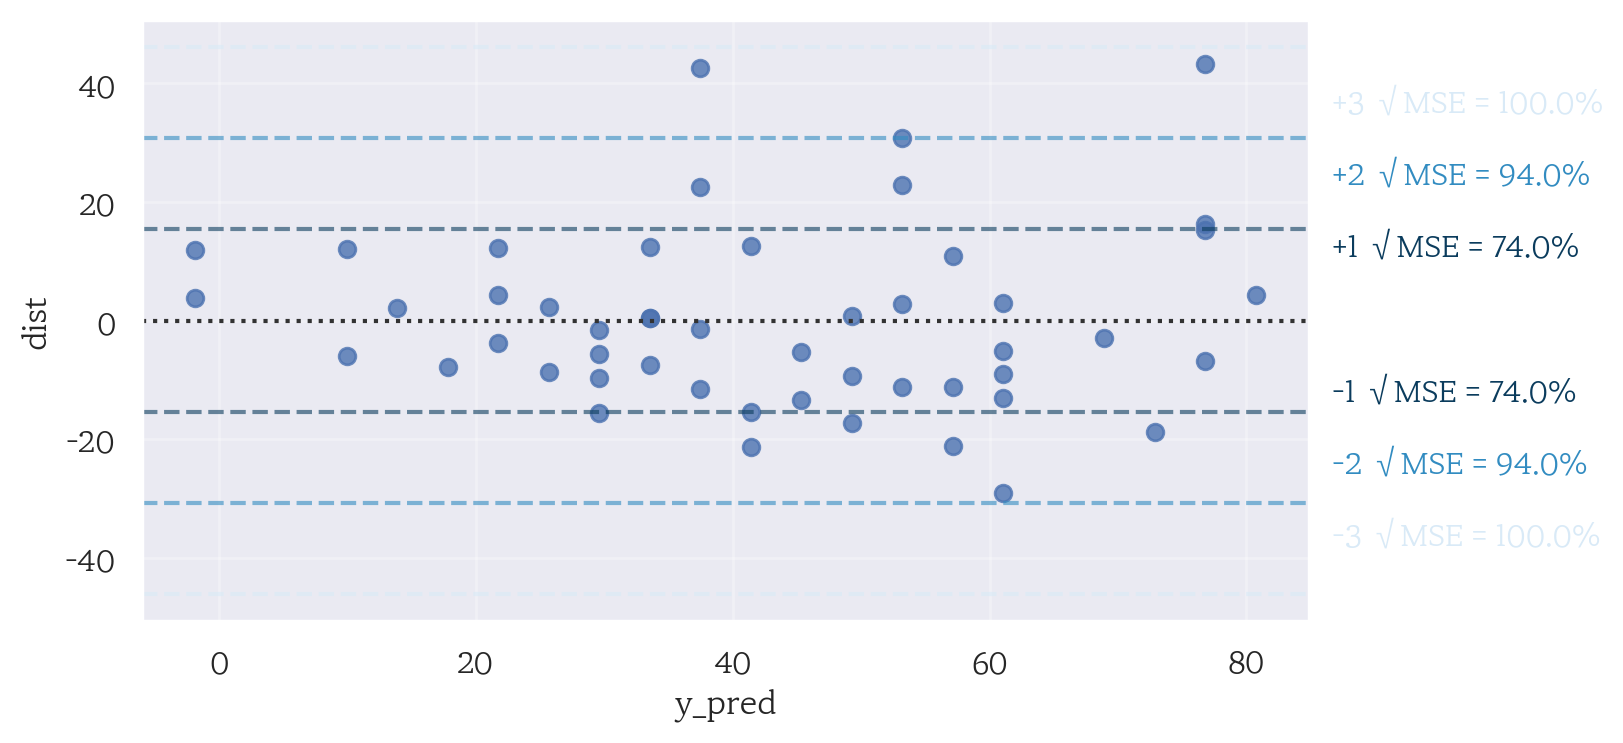

In [24]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]
xmax = df['y_pred'].max()
ymin = df['y_pred'].min()
# 1) 그래프 초기화
width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)
# 2) seaborn 기본 잔차도
sb.residplot(data=df, x='y_pred', y="dist", ax=ax)
# 3) 꾸미기
ax.grid(True, alpha=0.3)
# 4) MSE 3단계 표시
for i, c in enumerate(colors):
 k = i + 1
# 올바른 ±k√MSE 위치
 y_pos = k * mse_root
 ax.axhline(y= y_pos, color=c, linestyle="--", alpha=0.6)
 ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
# 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
 ax.text(x=1.02, y=0.5 + 0.12*k,
 s=f"+{k} √MSE = {mse_r[i]}%",
 transform=ax.transAxes,
 ha="left", va="center", fontsize=11, color=c)
 ax.text(x=1.02, y=0.5 - 0.12*k,
 s=f"-{k} √MSE = {mse_r[i]}%",
 transform=ax.transAxes,
 ha="left", va="center", fontsize=11, color=c)
# 5) 출력
plt.show()
plt.close()


## 검정 통계량을 사용한 검정

In [26]:
# 샘플 수에 따라 정규성 검정 선택
if len(origin) < 30:
    method = 'Shapiro-Wilk'
    s, p =shapiro(df['resid'])
else:
    method = 'Kolmogorov-Smirnov'
    mu = df['resid'].mean()
    sigma = df['resid'].std(ddof=1)
    
    s, p =kstest(df['resid'], 'norm', args = (mu, sigma))

# 결과 문자열
result = f'{method} Test ::: statistic: {s:.3f}, p-value: {p:.3f}, {'대립' if p <= 0.05 else '귀무'}가설 채택'
print(result)

Kolmogorov-Smirnov Test ::: statistic: 0.130, p-value: 0.341, 귀무가설 채택


## 잔차의 등분산성
### 브로이슈-패건 검정

In [29]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])
display(bp)
# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']
# 출력문 생성
bp_result = (
f"Breusch–Pagan Test //: "
f"F = {bp.loc['F Statistic','value']:.3f}, "
f"p-value = {p_bp:.3f}, "
f"{'대립' if p_bp <= 0.05 else '귀무'}가설 채택 → "
f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}"
)
print(bp_result)


,value
LM Statistic,3.214880
LM p-value,0.072972
F Statistic,3.298361
F p-value,0.075597


Breusch–Pagan Test //: F = 3.298, p-value = 0.076, 귀무가설 채택 → 등분산성 만족


## 잔차의 독립성

In [31]:
dw = durbin_watson(df['resid'])
if 1.5 <= dw <= 2.5:
 interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
 interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
 interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
print(f"Durbin–Watson = {dw:.3f} //: {interpretation}")

Durbin–Watson = 1.676 //: 잔차는 독립성을 만족함 (자기상관 없음)
